In [ ]:
%pip install qiskit[visualization]
%pip install qiskit_aer

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RYGate, RXGate, RZGate
from qiskit_aer import AerSimulator
import numpy as np

In [4]:
def computational_to_space_basis(vector):
  alpha = vector[0]
  beta = vector[1]
  gamma = np.angle(alpha)
  alpha_t = np.exp(-1j*gamma)*alpha
  beta_t = np.exp(-1j*gamma)*beta
  theta_by_two = np.arccos(alpha_t)
  theta = theta_by_two * 2
  sine_theta_by_two = np.sin(theta_by_two)
  exp_i_phi = (beta_t / sine_theta_by_two) if np.abs(sine_theta_by_two) > 0.000001 else 1
  phi = np.angle(exp_i_phi)
  a = np.sin(theta) * np.cos(phi)
  b = np.sin(theta) * np.sin(phi)
  c = np.cos(theta)
  x = np.array([a, b, c])
  return x

def space_to_computational_basis(vector):
  theta = np.arccos(vector[2])
  sine_phi = vector[1] / np.sin(theta) if np.abs(np.sin(theta)) > 0.000001 else 0
  phi_1 = np.arccos(vector[0]/ np.sin(theta)) if np.abs(np.sin(theta)) > 0.000001 else 0
  phi_2 = np.arcsin(sine_phi)
  if sine_phi < 0:
    phi_1 = 2 * np.pi - phi_1
  phi = phi_1
  theta_by_two = theta / 2
  alpha = np.cos(theta_by_two)
  beta = np.exp(1j * phi) * np.sin(theta_by_two)
  alpha_ortho = np.sin(theta_by_two)
  beta_ortho = -np.exp(1j * phi) * np.cos(theta_by_two)
  x = np.array([alpha, beta])
  y = np.array([alpha_ortho, beta_ortho])
  return x,y

In [5]:
def get_prime(vec_a, vec_b, theta):
    vec_a = np.array(vec_a)
    vec_b = np.array(vec_b)
    cos_alpha = np.abs(vec_a.conj().T @ vec_b)
    alpha = np.arccos(cos_alpha)
    p = (np.cos(-theta) - (np.cos(alpha) * np.cos(alpha + theta))) / (np.sin(alpha)) ** 2
    q = (np.cos(alpha + theta) - (np.cos(alpha) * np.cos(-theta))) / (np.sin(alpha)) ** 2
    return (p * vec_a) + (q * vec_b), (q * vec_a) + (p * vec_b)


In [6]:
# Discriminating the states psi and phi
# psi = Statevector([1, 0]).evolve(RXGate(-2 * np.pi / 3)).evolve(RZGate(-np.pi / 6)).data
# phi = np.array([0.6, 0.8])

# Discriminating between the states |0> and |+>
psi = np.array([1, 0])
phi = np.sqrt(1 / 2) * np.array([1, 1])

angle = np.arccos(psi.conj().T @ phi)
angle_apply = (np.pi / 2 - angle) / 2

# Trasforming from computational to space basis to finde the orthogonal basis upon which we can do measurement i.e. P and P_ortho
# A = computational_to_space_basis(psi)
# B = computational_to_space_basis(phi)

# x = np.sqrt((1 / (2 * (1 - A.dot(B)))))
# y = -x
# P = (x * A) + (y * B)
P, P_ortho = get_prime(psi, phi, angle_apply)

# The unitary for P-basis measurement
U = np.array([P.conj().T, P_ortho.conj().T])

# The success probability
Pr_success = (1 / 2) * (1 + np.sin(np.arccos(np.abs(phi.conj().T @ psi))))
print(Pr_success)


0.8535533905932737


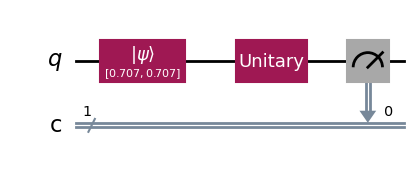

In [7]:
qc = QuantumCircuit(1, 1)
qc.initialize(phi, 0)
qc.unitary(U, 0)
qc.measure(0, 0)

qc.draw('mpl')


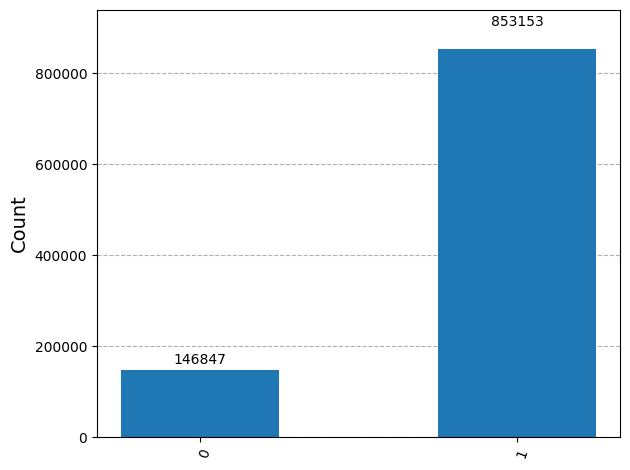

In [8]:
aersim = AerSimulator()
qc = transpile(qc,aersim)
job = aersim.run(qc, shots=1000000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)